In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

# Pascal VOC dataset

In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/models'),
 PosixPath('data/pascal/count2.csv'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/largest.csv'),
 PosixPath('data/pascal/pascal'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/tmp'),
 PosixPath('data/pascal/VOC2007'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/VOC2012'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/count.csv'),
 PosixPath('data/pascal/.ipynb_checkpoints'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_val2007.json')]

In [4]:
train_json = json.load((PATH / 'pascal_train2007.json').open())

### Explore dataset

In [5]:
train_json.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
len(train_json['images'])

2501

In [7]:
train_json['images'][:3]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}]

In [8]:
len(train_json['annotations'])

7844

In [9]:
train_json['annotations'][0]

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [10]:
train_json['categories']

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'},
 {'id': 5, 'name': 'bottle', 'supercategory': 'none'},
 {'id': 6, 'name': 'bus', 'supercategory': 'none'},
 {'id': 7, 'name': 'car', 'supercategory': 'none'},
 {'id': 8, 'name': 'cat', 'supercategory': 'none'},
 {'id': 9, 'name': 'chair', 'supercategory': 'none'},
 {'id': 10, 'name': 'cow', 'supercategory': 'none'},
 {'id': 11, 'name': 'diningtable', 'supercategory': 'none'},
 {'id': 12, 'name': 'dog', 'supercategory': 'none'},
 {'id': 13, 'name': 'horse', 'supercategory': 'none'},
 {'id': 14, 'name': 'motorbike', 'supercategory': 'none'},
 {'id': 15, 'name': 'person', 'supercategory': 'none'},
 {'id': 16, 'name': 'pottedplant', 'supercategory': 'none'},
 {'id': 17, 'name': 'sheep', 'supercategory': 'none'},
 {'id': 18, 'name': 'sofa', 'supercategory': 'none'},
 {'id': 

In [11]:
list((PATH/'VOC2007').iterdir())

[PosixPath('data/pascal/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOC2007/Annotations'),
 PosixPath('data/pascal/VOC2007/ImageSets')]

In [12]:
list((PATH/'VOC2007'/'JPEGImages').iterdir())[:10]

[PosixPath('data/pascal/VOC2007/JPEGImages/000052.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/003344.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/001941.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/008160.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/008203.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/002933.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/000099.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/007736.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/001293.jpg'),
 PosixPath('data/pascal/VOC2007/JPEGImages/001409.jpg')]

### Create data structures

In [13]:
categories = {category['id']:category['name'] for category in train_json['categories']}

In [14]:
categories[1], categories[7]

('aeroplane', 'car')

In [15]:
image_props = {}

for image in train_json['images']:
    image_props[image['id']] = {
        'filename' : image['file_name'],
        'objects' :[]
    }

for annotation in train_json['annotations']:
    if not annotation['ignore']:
        image_props[annotation['image_id']]['objects'].append((annotation['category_id'], annotation['bbox']))

### Display image

In [16]:
%matplotlib inline

In [17]:
def sort_by_size(obj):
    return sorted(obj, key=lambda x : x[1][2] * x[1][3], reverse=True)

In [18]:
def draw_outline(obj, width):
    obj.set_path_effects([patheffects.Stroke(linewidth=width, foreground='black'), patheffects.Normal()])

def draw_bbox(ax, obj):    
    category, bbox = obj
    patch = ax.add_patch(patches.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2], height=bbox[3], 
                                           fill=False, edgecolor='yellow', lw=2))
    draw_outline(patch, 4)
    text = ax.text(bbox[0], bbox[1], s=categories[category], color='black', fontsize=12,
                   verticalalignment='bottom',
                   bbox=dict(facecolor='yellow', pad=2))
    
def draw_image(id, largest=False):
    fig, ax = plt.subplots(figsize=(16,8))
    img = open_image(PATH/'VOC2007'/'JPEGImages'/image_props[id]['filename'])
    
    # sort bboxes by size, used later
    sorted_bboxes = sort_by_size(image_props[id]['objects'])
    
    for obj in sorted_bboxes:
        draw_bbox(ax, obj)
        if largest:
            break
            
    ax.imshow(img);

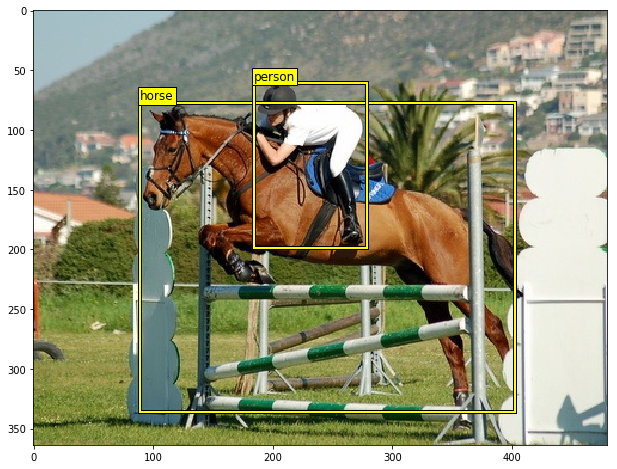

In [19]:
draw_image(17)

# Largest item classifier

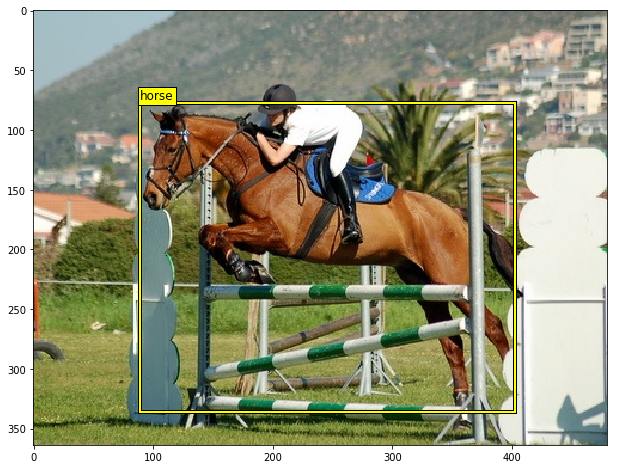

In [20]:
draw_image(17, largest=True)

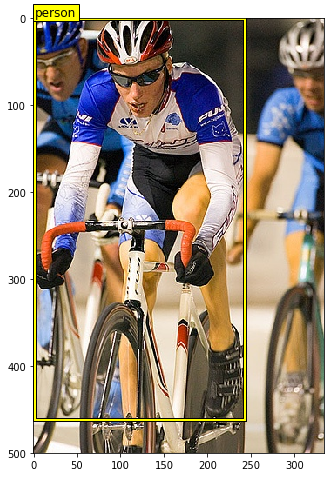

In [21]:
draw_image(23, largest=True)

In [22]:
largest_objects = {img_prop['filename']:categories[sort_by_size(img_prop['objects'])[0][0]] 
                   for k, img_prop in image_props.items()}

In [23]:
largest_df = pd.DataFrame.from_dict(largest_objects, orient='index')
largest_df.head()

,0
000012.jpg,car
000017.jpg,horse
000023.jpg,person
000026.jpg,car
000032.jpg,aeroplane


In [65]:
LARGEST_CSV = PATH/'largest.csv'
largest_df.to_csv(LARGEST_CSV)

In [84]:
model = resnet34
sz = 224
bs = 64
JPEGS = 'VOC2007/JPEGImages'

In [85]:
tfms = tfms_from_model(model, sz, transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, LARGEST_CSV, bs, tfms)

In [86]:
x, y = next(iter(md.val_dl)) # first minibatch

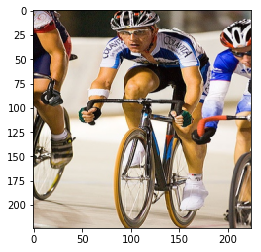

In [90]:
plt.imshow(md.trn_ds.denorm(to_np(x))[0]);

In [110]:
learner = ConvLearner.pretrained(model, md, metrics=[accuracy])

In [111]:
learner.lr_find(1e-5, 100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|████████▍ | 27/32 [00:08<00:01,  3.01it/s, loss=14.4]


In [ ]:
learner.sched.plot(3, 1)

### Train model

In [113]:
lr = 2e-2
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.915239   0.963518   0.724159  



[0.9635179, 0.7241586521267891]

In [114]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.10667    0.718483   0.804537  



[0.7184831, 0.804537259042263]

In [115]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.938643   0.644283   0.80649   



[0.64428306, 0.806490384042263]

In [117]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.753351   0.59374    0.814754  



[0.59373987, 0.8147536069154739]

In [118]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.696061   0.582894   0.810847  



[0.58289397, 0.8108473569154739]

In [119]:
learner.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.667076   0.556772   0.822566  



[0.55677205, 0.8225661069154739]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 78%|███████▊  | 25/32 [00:16<00:04,  1.54it/s, loss=1.4]  

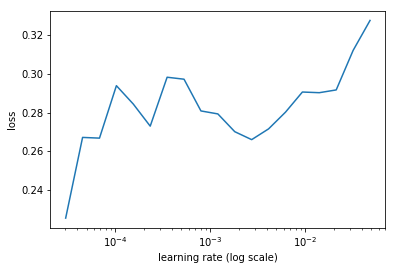

In [121]:
lrs = np.array([lr/1000,lr/100,lr])

learn.freeze_to(-2)

lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [122]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 41%|████      | 13/32 [00:08<00:12,  1.49it/s, loss=0.31] 

Exception in thread Thread-55:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                  
    0      0.354537   0.594796   0.832782  



[0.594796, 0.8327824547886848]

In [123]:
learn.unfreeze()

In [124]:
learn.fit(lrs/5, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.296934   0.581716   0.846004  
    1      0.217254   0.607618   0.851412                  



[0.6076183, 0.851412259042263]

In [125]:
x, y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)

In [126]:
preds

array([[0.     , 0.13001, 0.     , ..., 0.     , 0.00001, 0.00001],
       [0.00001, 0.00005, 0.00001, ..., 0.71361, 0.00001, 0.00008],
       [0.00008, 0.00001, 0.98656, ..., 0.     , 0.00001, 0.00003],
       ...,
       [0.     , 0.00001, 0.     , ..., 0.03524, 0.     , 0.00001],
       [0.     , 0.     , 0.     , ..., 0.00005, 0.     , 0.     ],
       [0.0003 , 0.0001 , 0.00018, ..., 0.00002, 0.00011, 0.00047]], dtype=float32)

In [127]:
preds = np.argmax(preds, -1)

In [128]:
preds

array([14, 17,  2, 14, 14,  6, 13, 10,  2,  9, 15,  6, 17,  7, 12,  0, 14, 14,  7, 19,  1,  8, 14, 13, 14,
       14, 14,  5,  9, 18, 13,  0,  2,  6, 18, 11, 14,  6,  0, 10,  6, 13, 12, 14,  3, 13, 14,  7, 12, 13,
        9, 14, 13,  2, 14, 11,  6,  0,  2,  2,  2,  7, 14,  9])

In [82]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


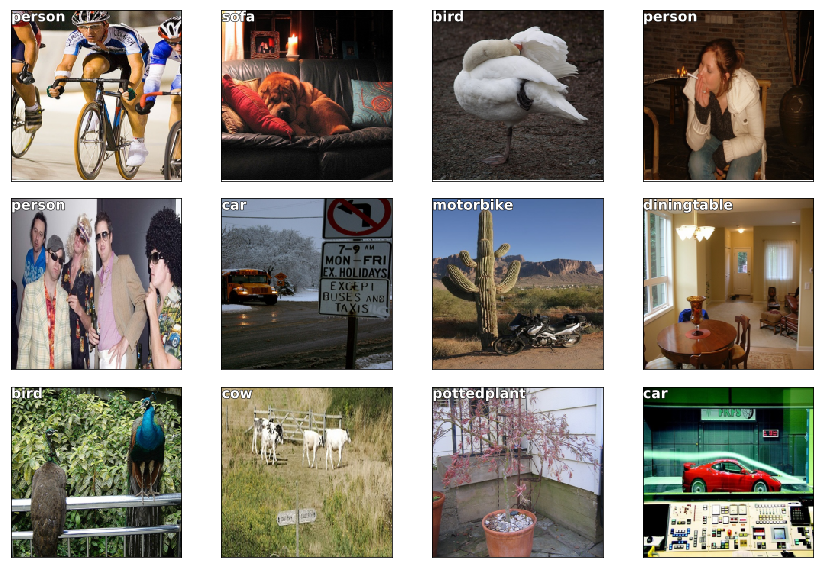

In [139]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    txt = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), txt)
plt.tight_layout()

### Known object counter

In [140]:
obj_count = {img_prop['filename']:len(img_prop['objects']) for k, img_prop in image_props.items()}

In [142]:
df = pd.DataFrame.from_dict(obj_count, orient='index').reset_index()
df.head()

,index,0
0,000012.jpg,1
1,000017.jpg,2
2,000023.jpg,5
3,000026.jpg,1
4,000032.jpg,4


In [147]:
COUNT_CSV = PATH/'count.csv'
df.to_csv(COUNT_CSV, index=False)

In [148]:
model = resnet34
sz=224
bs = 64
JPEGS = 'VOC2007/JPEGImages'

In [149]:
tfms = tfms_from_model(model, sz, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, COUNT_CSV, tfms=tfms, continuous=True)

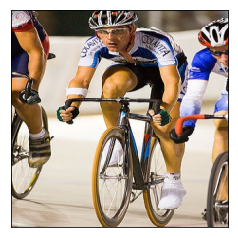

In [155]:
x,y=next(iter(md.val_dl))
show_img(md.val_ds.denorm(to_np(x))[0]);

In [158]:
to_np(y[0])

array([3.], dtype=float32)

In [159]:
head_reg = nn.Sequential(Flatten(), nn.Linear(25088, 1)) # resnet last lyr = 7 * 7 * 512 = 25088, 1 outputs for number of objects
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 56%|█████▋    | 18/32 [00:06<00:04,  2.98it/s, loss=12.4]


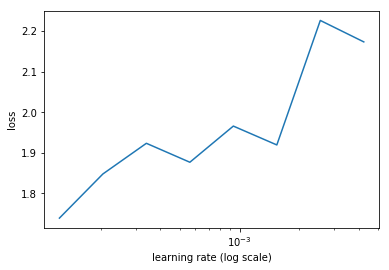

In [160]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

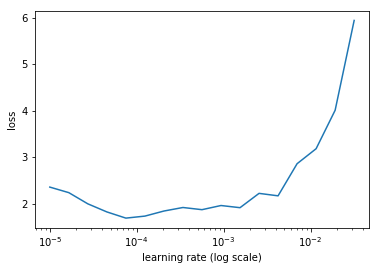

In [163]:
learn.sched.plot(0,1)

In [164]:
lr = 5e-5

In [165]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      1.658874   1.511142  
    1      1.506676   1.349454                            
    2      1.360818   1.319122                            



[1.3191222]

In [166]:
lrs = np.array([lr/100,lr/10,lr])

In [167]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 19%|█▉        | 6/32 [00:04<00:18,  1.39it/s, loss=1.2]  


Exception in thread Thread-66:
Traceback (most recent call last):
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rohit/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 75%|███████▌  | 24/32 [00:15<00:05,  1.56it/s, loss=6.02]


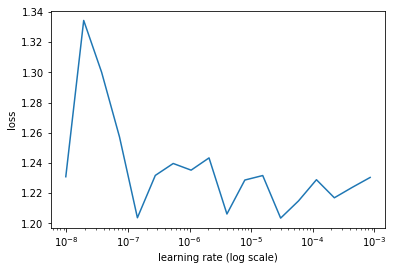

In [170]:
lrf=learn.lr_find(lrs/10000)
learn.sched.plot(1)

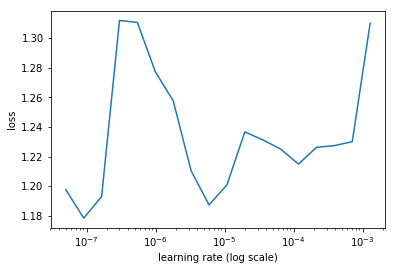

In [169]:
learn.sched.plot(0)

In [171]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      1.211947   1.248706  
    1      1.129751   1.206204                            
    2      1.02571    1.17982                             



[1.1798203]

In [172]:
learn.freeze_to(-3)

In [173]:
learn.fit(lrs, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.949465   1.202279  
    1      0.873774   1.125137                             



[1.1251369]

In [174]:
learn.save('counter')

In [175]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


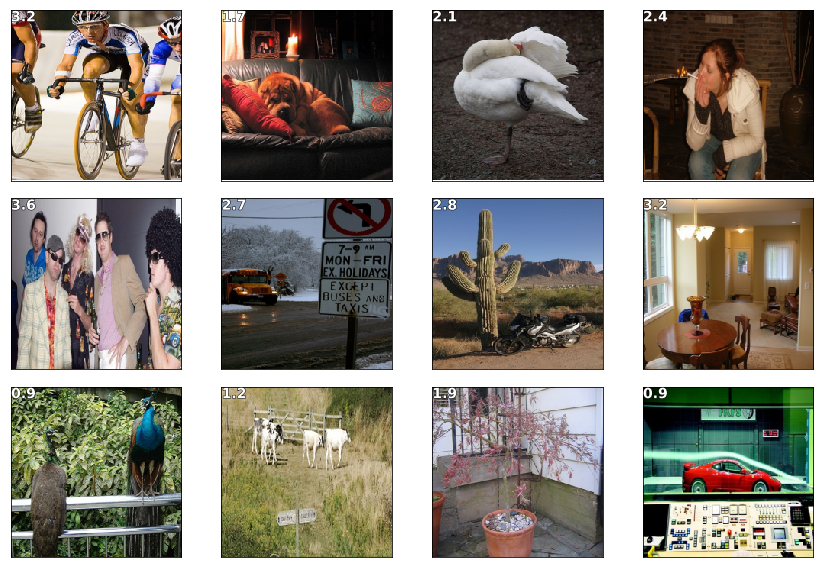

In [190]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    
    txt = '{0:.1f}'.format(preds[i][0])
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), txt)
plt.tight_layout()

In [198]:
for fn in md.val_ds.fnames[:12]:
    print(fn[len('VOC2007/JPEGImages/'):] + ' - ' + str(obj_count[fn[len('VOC2007/JPEGImages/'):]]))

000129.jpg - 3
000140.jpg - 2
000189.jpg - 1
000192.jpg - 1
000200.jpg - 7
000207.jpg - 1
000219.jpg - 1
000235.jpg - 3
000294.jpg - 2
000306.jpg - 3
000307.jpg - 2
000317.jpg - 1
